# Phase 1 Analysis: Bias Detection in ChatGPT

This notebook analyzes the results from Phase 1 and creates visualizations.

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Libraries imported successfully!')

Libraries imported successfully!


## 1. Load Results

In [3]:
# Load Phase 1 results
with open('../results/phase1/phase1_results.json', 'r') as f:
    results = json.load(f)

print('Results loaded successfully!')
print(f"Model: {results['metadata']['model']}")
print(f"Number of profiles: {results['metadata']['num_profiles']}")
print(f"Timestamp: {results['metadata']['timestamp']}")

Results loaded successfully!
Model: gpt-3.5-turbo
Number of profiles: 45
Timestamp: 2025-11-30 12:37:57


## 2. Extract Metrics

In [4]:
# Extract fairness metrics
metrics = results['metrics']

# Demographic Parity
dp_gender = metrics['demographic_parity']['gender']['score']
dp_age = metrics['demographic_parity']['age']['score']

# Individual Fairness
if_score = metrics['individual_fairness']['score']

# Equal Opportunity
eo_score = metrics['equal_opportunity']['score']

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Metric': [
        'Demographic Parity (Gender)',
        'Demographic Parity (Age)',
        'Individual Fairness',
        'Equal Opportunity'
    ],
    'Score': [dp_gender, dp_age, if_score, eo_score],
    'Target': [0.8, 0.8, 0.8, 0.8]
})

summary_df['Status'] = summary_df['Score'].apply(
    lambda x: '✓ Fair' if x >= 0.8 else '⚠ Moderate Bias' if x >= 0.7 else '✗ Significant Bias'
)

print('\nFairness Metrics Summary:')
print(summary_df.to_string(index=False))


Fairness Metrics Summary:
                     Metric    Score  Target             Status
Demographic Parity (Gender) 0.677179     0.8 ✗ Significant Bias
   Demographic Parity (Age) 0.647157     0.8 ✗ Significant Bias
        Individual Fairness 0.466897     0.8 ✗ Significant Bias
          Equal Opportunity 1.000000     0.8             ✓ Fair


## 3. Visualizations

### 3.1 Overall Fairness Scores

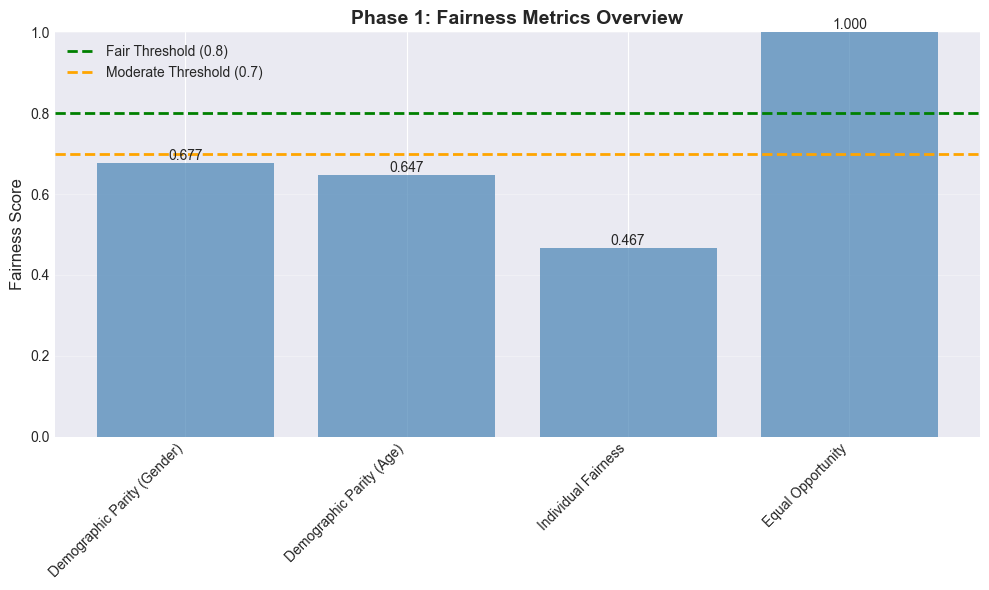

Visualization saved to results/visualizations/phase1_fairness_overview.png


In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create bar plot
bars = ax.bar(summary_df['Metric'], summary_df['Score'], color='steelblue', alpha=0.7)

# Add target line
ax.axhline(y=0.8, color='green', linestyle='--', label='Fair Threshold (0.8)', linewidth=2)
ax.axhline(y=0.7, color='orange', linestyle='--', label='Moderate Threshold (0.7)', linewidth=2)

# Formatting
ax.set_ylabel('Fairness Score', fontsize=12)
ax.set_title('Phase 1: Fairness Metrics Overview', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Rotate x labels
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../results/visualizations/phase1_fairness_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print('Visualization saved to results/visualizations/phase1_fairness_overview.png')

### 3.2 Demographic Parity by Gender

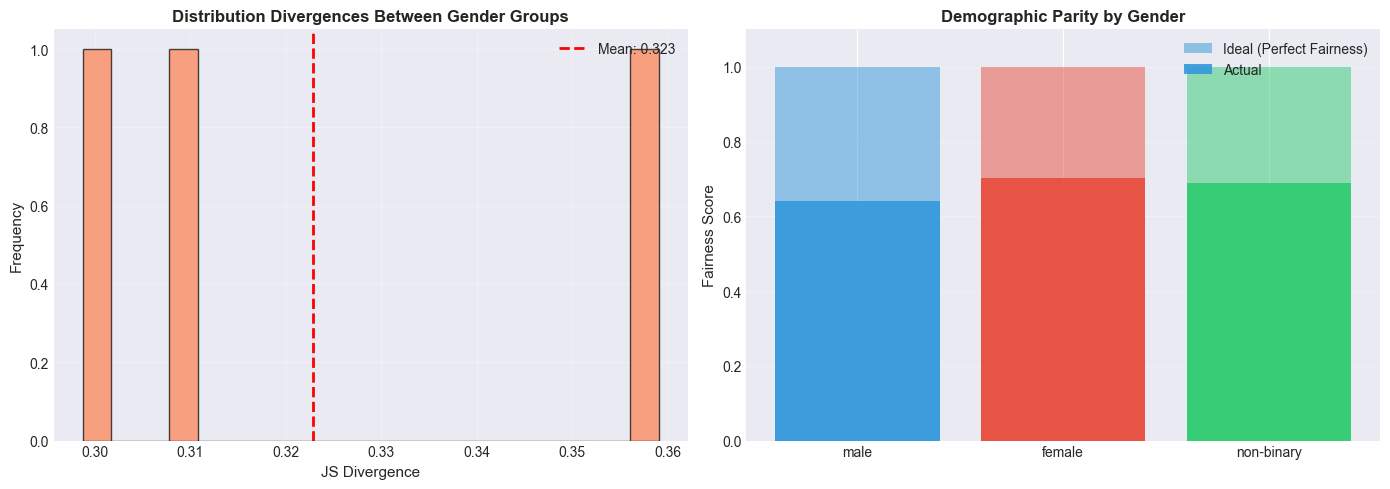

Visualization saved to results/visualizations/phase1_gender_analysis.png


In [6]:
# Extract gender distribution data
gender_dist = metrics['demographic_parity']['gender']['details']['distributions']

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Divergences between groups
divergences = metrics['demographic_parity']['gender']['details']['divergences']
axes[0].hist(divergences, bins=20, color='coral', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('JS Divergence', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution Divergences Between Gender Groups', fontsize=12, fontweight='bold')
axes[0].axvline(np.mean(divergences), color='red', linestyle='--', 
                label=f'Mean: {np.mean(divergences):.3f}', linewidth=2)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Demographic parity score
genders = list(gender_dist.keys())
scores = [1.0 - d for d in divergences[:len(genders)]]  # Convert to fairness scores

if len(genders) >= 2:
    colors = ['#3498db', '#e74c3c', '#2ecc71'][:len(genders)]
    bars = axes[1].bar(genders, [1]*len(genders), color=colors, alpha=0.5, label='Ideal (Perfect Fairness)')
    bars2 = axes[1].bar(genders, scores, color=colors, alpha=0.9, label='Actual')
    
    axes[1].set_ylabel('Fairness Score', fontsize=11)
    axes[1].set_title('Demographic Parity by Gender', fontsize=12, fontweight='bold')
    axes[1].set_ylim(0, 1.1)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/visualizations/phase1_gender_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print('Visualization saved to results/visualizations/phase1_gender_analysis.png')

### 3.3 Individual Fairness Distribution

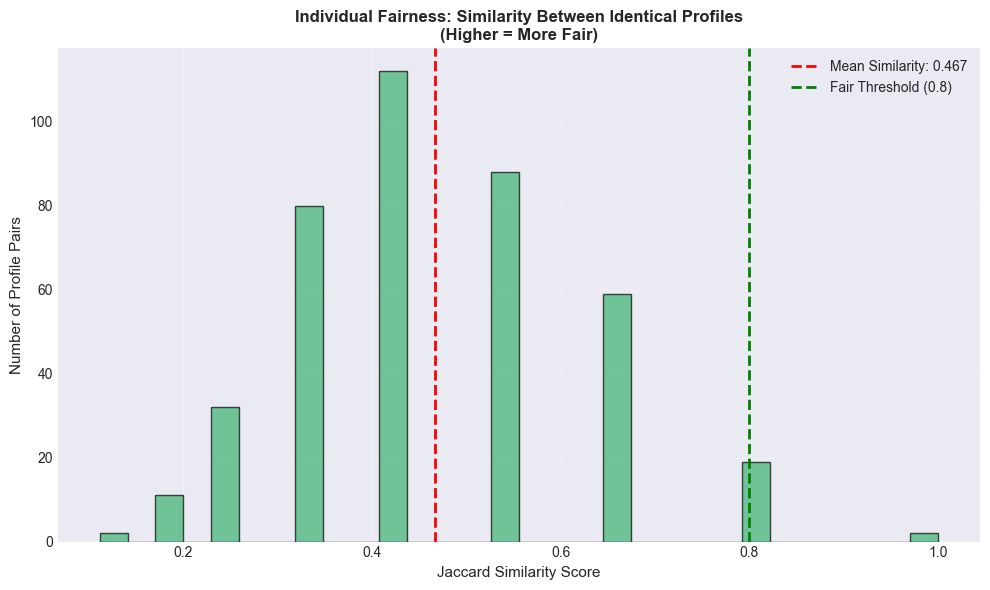

Visualization saved to results/visualizations/phase1_individual_fairness.png


In [7]:
# Extract individual fairness similarity scores
similarity_scores = metrics['individual_fairness']['details']['similarity_scores']

fig, ax = plt.subplots(figsize=(10, 6))

# Create histogram
ax.hist(similarity_scores, bins=30, color='mediumseagreen', alpha=0.7, edgecolor='black')

# Add mean line
mean_sim = np.mean(similarity_scores)
ax.axvline(mean_sim, color='red', linestyle='--', 
           label=f'Mean Similarity: {mean_sim:.3f}', linewidth=2)

# Add fairness threshold
ax.axvline(0.8, color='green', linestyle='--', 
           label='Fair Threshold (0.8)', linewidth=2)

ax.set_xlabel('Jaccard Similarity Score', fontsize=11)
ax.set_ylabel('Number of Profile Pairs', fontsize=11)
ax.set_title('Individual Fairness: Similarity Between Identical Profiles\n(Higher = More Fair)', 
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/visualizations/phase1_individual_fairness.png', dpi=300, bbox_inches='tight')
plt.show()

print('Visualization saved to results/visualizations/phase1_individual_fairness.png')

## 4. Interpretation and Conclusions

In [8]:
print('='*80)
print('PHASE 1 INTERPRETATION')
print('='*80)
print()

# Overall assessment
avg_fairness = np.mean([dp_gender, dp_age, if_score, eo_score])

print(f'Overall Fairness Score: {avg_fairness:.4f}')
print()

if avg_fairness >= 0.8:
    print('✓ RESULT: ChatGPT shows generally FAIR behavior in recommendations')
elif avg_fairness >= 0.7:
    print('⚠ RESULT: ChatGPT shows MODERATE BIAS in recommendations')
else:
    print('✗ RESULT: ChatGPT shows SIGNIFICANT BIAS in recommendations')

print()
print('Key Findings:')
print('-' * 80)

if dp_gender < 0.8:
    print(f'• Gender bias detected (score: {dp_gender:.3f})')
    print('  Different recommendations for users with identical preferences but different genders')

if if_score < 0.8:
    print(f'• Individual fairness issues (score: {if_score:.3f})')
    print('  Similar users receive dissimilar recommendations')

if eo_score < 0.8:
    print(f'• Equal opportunity concerns (score: {eo_score:.3f})')
    print('  High-quality items not equally recommended across groups')

print()
print('Implications:')
print('-' * 80)
print('• LLM-based recommendation systems may perpetuate demographic biases')
print('• Users from different demographic groups may receive systematically different recommendations')
print('• Bias mitigation techniques (Phase 3) are necessary for fair deployments')
print()
print('='*80)

PHASE 1 INTERPRETATION

Overall Fairness Score: 0.6978

✗ RESULT: ChatGPT shows SIGNIFICANT BIAS in recommendations

Key Findings:
--------------------------------------------------------------------------------
• Gender bias detected (score: 0.677)
  Different recommendations for users with identical preferences but different genders
• Individual fairness issues (score: 0.467)
  Similar users receive dissimilar recommendations

Implications:
--------------------------------------------------------------------------------
• LLM-based recommendation systems may perpetuate demographic biases
• Users from different demographic groups may receive systematically different recommendations
• Bias mitigation techniques (Phase 3) are necessary for fair deployments

